In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

In [3]:
def get_wordnet_pos(word):
    '''Mapping POS tags'''
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_tweets(tweets):
    '''Cleaning and lemmatizing tweets for further analysis'''
    
    tweets = tweets.str.lower().drop_duplicates()
    
    #removes links
    tweets = tweets.apply(lambda x: re.sub(r'http\S+', '', x))
    
    #removes twitter usernames
    tweets = tweets.apply(lambda x: re.sub(r'(\s)@\w+', '', x))
    
    #removes non-alpha numeric symbols
    tweets = tweets.apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    #removes stop words
    custom_stop_words = ['rt', 'amp', 'u', 'w', 'im']
    stop_words = custom_stop_words + stopwords.words('english')
    tweets = tweets.apply(lambda x: ' '.join([item for item in str(x).split() if item not in stop_words]))
    
    #replace line indents with spaces
    tweets = tweets.apply(lambda x: re.sub(r'\n',' ', x))
    
    #turn data into a list of tweets
    tweet_list = [i for i in tweets]
    
    #initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    #lemmatize the words
    lemmatized_tweets = []
    for tweet in tweet_list:
        lemmatized_tweets.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(tweet)])
    
    #combine the words back into tweets
    out_list = []
    for tweet in lemmatized_tweets:
        out_list.append(' '.join(tweet))
    
    return(out_list)

In [4]:
national_data_files = ['joebiden_tweets.csv', 'AOC_tweets.csv', 'SpeakerPelosi_tweets.csv',
             'SenatorCollins_tweets.csv', 'tedcruz_tweets.csv', 'Mike_Pence_tweets.csv',
              'HowieHawkins_tweets.csv']

local_data_files = ['CouncilPresBMS_tweets.csv', 'Mfume4Congress_tweets.csv',
              'mia4md_tweets.csv', 'Wrightforbalti1_tweets.csv', 'kimKBaltimore_tweets.csv',
              'GovLarryHogan_tweets.csv', 'RobertLWallace_tweets.csv']

def create_dictionaries_of_tweets(file_list):
    '''Creates a dictionary of tweets for each politician'''
    
    out_dict = {}
    for file in file_list:
        df = pd.read_csv(f'data/{file}')
        handle = file.split('_tweets')[0]
        out_dict[handle] = clean_tweets(df['tweet_text'])
    return(out_dict)

national_politicians = create_dictionaries_of_tweets(national_data_files)
local_politicians = create_dictionaries_of_tweets(local_data_files)

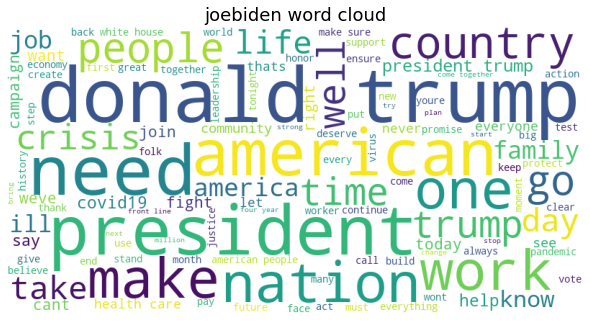

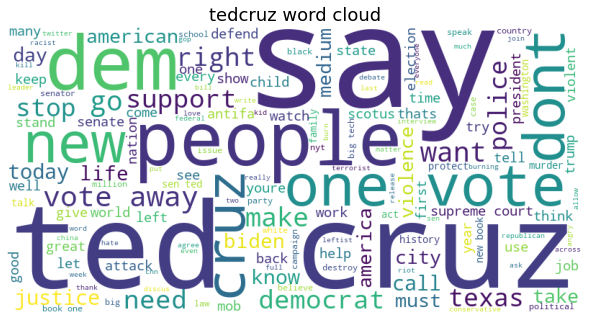

In [32]:
def plot_wordcloud(my_dict, politician):
    '''Plots a word cloud for text of given politicians Tweets'''
    
    wordcloud = WordCloud(width = 800, height = 400, 
                          background_color ='white', 
                          min_font_size = 10).generate(''.join(my_dict[politician]))

    fig, ax = plt.subplots(figsize = (8, 8), facecolor = None)
    plt.title(f'{politician} word cloud', fontsize=18)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 
    
    return(fig)

biden_wordcloud = plot_wordcloud(national_politicians, 'joebiden')
cruz_wordcloud = plot_wordcloud(national_politicians, 'tedcruz')

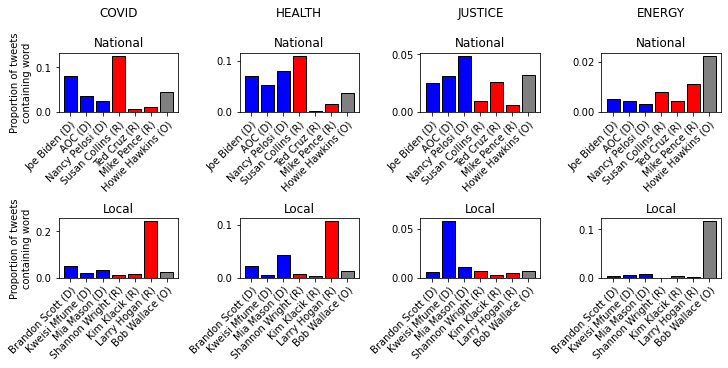

In [4]:
words = ['covid', 'health', 'justice', 'energy']

labels_national = ('Joe Biden (D)', 'AOC (D)', 'Nancy Pelosi (D)','Susan Collins (R)', 
                       'Ted Cruz (R)', 'Mike Pence (R)', 'Howie Hawkins (O)')

labels_local = ('Brandon Scott (D)', 'Kweisi Mfume (D)', 'Mia Mason (D)', 'Shannon Wright (R)', 
                    'Kim Klacik (R)', 'Larry Hogan (R)', 'Bob Wallace (O)')

def calculate_word_frequency(query_word, candidates):
    return([sum(1 for tweet in candidate if query_word in tweet) / len(candidate) for key, candidate in candidates.items()])

fig, ax = plt.subplots(2,4, figsize = (10,5), constrained_layout=True)
for i, word in enumerate(words):

    word_frequency_national = calculate_word_frequency(word, national_politicians)

    word_frequency_local = calculate_word_frequency(word, local_politicians)

    colors = ('blue', 'blue', 'blue', 'red', 'red', 'red', 'gray')
    #plt.suptitle(f'{word}'.upper(), fontsize=18)
    ax[0][i].bar(labels_national, word_frequency_national, color=colors, edgecolor='k')
    ax[1][i].bar(labels_local, word_frequency_local, color=colors, edgecolor='k')
    plt.setp(ax[0][i].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax[1][i].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax[0][i].set_title(f'{word.upper()}\n\nNational')
    ax[1][i].set_title('Local')
ax[0][0].set_ylabel('Proportion of tweets\ncontaining word')
ax[1][0].set_ylabel('Proportion of tweets\ncontaining word')
fig.savefig('figures/politician_word_frequencies.png', dpi = 300, bbox_inches='tight')
plt.show()

This figure plots the proportion of Tweets by each politicians that contains the indicated word at the top of each panel. National politicians are shown on the top row and local politicians from the state of Maryland are shown on the bottom row. 

In many cases, local and national politicians from a common party show similarly increased or decreased usage of specific words relative to politicians from the opposing political party. For example, Democrats at both the national and local level tend to have more Tweets with the word 'justice' than their republican counterparts, possibly reflecting a higher priority of social and/or crimial justice reform. 

However, politicians within the same party show some differences in the frequency of Tweets on a given topic. For example, while Ted Cruz and Mike Pence have very few tweets with the word 'COVID', Susan Collins has many. Similarly on the local level, Republicans Shannon Wright and Kim Klacik Tweet infrequently about COVID, but Larry Hogan Tweets often. Thus, we can likely indentify specific similarities among politicians within parties as well.

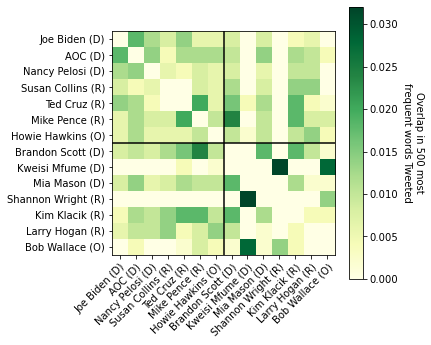

In [9]:
all_politicians = {**national_politicians, **local_politicians}
all_labels = labels_national + labels_local

most_common_words = []
for key, value in all_politicians.items():
    tweet_word_list = [i.split() for i in value]
    tweet_word_list_flat = [item for sublist in tweet_word_list for item in sublist]
    word_counts = Counter(tweet_word_list_flat).most_common(500)
    most_common_words.append(set(word_counts))
    
overlap = np.zeros((len(most_common_words), len(most_common_words)))
for i in range(len(most_common_words)):
    for j in range(i+1, len(most_common_words)):
        overlap[i][j] = overlap[j][i] = len(list(most_common_words[i] & most_common_words[j])) / len(most_common_words[i])

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(overlap, cmap="YlGn")
ax.set_xticks(np.arange(len(all_labels)))
ax.set_yticks(np.arange(len(all_labels)))
ax.set_xticklabels(all_labels)
ax.set_yticklabels(all_labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Overlap in 500 most\nfrequent words Tweeted', rotation=-90, va="bottom")
ax.axhline(6.5, color='k')
ax.axvline(6.5, color='k')
fig.savefig('figures/most_frequent_word_overlaps.png', dpi = 300, bbox_inches='tight')
plt.show()

This figure shows the proportion of overlap among the top 500 most frequently Tweeted words between all politicians. The black lines within the plot separate the national and the local politicians. Politicians that most often Tweet about simiar issues may be expected to be similary in ideologies.

These analyses can be further improved by including the sentiment of the Tweets. For example, Joe Biden and Ted Cruz may have many Tweets about the same topic, but sentiment of the Tweets may reflect opposing ideas.